In [ ]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col, max as max_, when, count, avg, expr, explode
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import lit
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

conf = SparkConf().setAppName('Google Merchandise Recommendation System')
sc = SparkContext.getOrCreate(conf = conf)

spark = SparkSession.builder\
        .master("local")\
        .appName("Colab")\
        .config('spark.ui.port', '4050')\
        .getOrCreate()

# **Importing Dataset**

In [ ]:
events_df = spark.read.csv("/content/events1.csv", header=True)
items_df = spark.read.csv("/content/items.csv", header=True)
users_df = spark.read.csv("/content/users.csv", header=True)

# **Data Pre-Processing**

In [ ]:
#Dropping columns which are not required for recommendation
events_df = events_df.drop("ga_session_id").drop("date").drop("device")

items_df = items_df.drop("brand").drop("price_in_usd").drop("variant")
items_df = items_df.withColumnRenamed("id", "item_id")

final_df = events_df.join(items_df, on="item_id", how="inner")
final_df = final_df.withColumn('item_id', final_df['item_id'].cast(IntegerType()))
final_df = final_df.withColumn('user_id', final_df['user_id'].cast(IntegerType()))

# Checking NULL values
for column in final_df.columns:
    print(column,final_df.filter(col(column).isNull()).count())

final_df = final_df.dropna(subset=["country"])
final_df = final_df.dropDuplicates()

final_df.show(5)
final_df.count()

item_id 0
user_id 0
country 4562
type 0
name 0
category 0
+-------+-------+-------+-----------+--------------------+-----------------+
|item_id|user_id|country|       type|                name|         category|
+-------+-------+-------+-----------+--------------------+-----------------+
|   1068|   5808|     US|add_to_cart|Google Eco Tee Black|          Apparel|
|    406|  20141|     US|   purchase|Google Chicago Ca...|Campus Collection|
|    280|   9745|     US|   purchase|Google Sherpa Zip...|          Apparel|
|    385|  25157|     IE|   purchase|  Android Iconic Pen|              New|
|     53|  29052|     IN|   purchase|Google Sherpa Zip...|          Apparel|
+-------+-------+-------+-----------+--------------------+-----------------+
only showing top 5 rows



295037

In [ ]:
# Calculating Total interaction counts by grouping 'type',`'category', and 'country' columns
interaction_counts = final_df.groupBy("type","category","country").agg(count("*").alias("count"))

# Calculating maximum count across all
max_count = interaction_counts.agg(max_("count").alias("max_count")).collect()[0]["max_count"]

# Calculating and Normalizing weights by dividing the count by global maximum count
interaction_counts_with_weights = interaction_counts.withColumn(
    "weight",
    (col("count") / max_count)
)

#Updated interaction counts with weights
interaction_counts_with_weights.show()

#Joining calculated weights back to the final dataset
final_df = final_df.join(
    interaction_counts_with_weights.select("type", "category", "country", "weight"),
    on=["type", "category", "country"],
    how="left"
)

final_df.show()

+--------------+-------------------+-------+-----+--------------------+
|          type|           category|country|count|              weight|
+--------------+-------------------+-------+-----+--------------------+
|   add_to_cart|Uncategorized Items|     IN|  581|0.013083522868016303|
|      purchase|            Apparel|     TW|   77|0.001733960862026...|
|   add_to_cart|                New|     TW|  575| 0.01294840903461166|
|   add_to_cart|  Campus Collection|     SE|   69|0.001553809084153...|
|   add_to_cart|          Clearance|     ES|  268|0.006035084558740739|
|      purchase|          Lifestyle|     HU|    1|2.251897223410723...|
|begin_checkout|             Office|     BR|   15|3.377845835116085...|
|      purchase|  Campus Collection|     NL|   17| 3.82822527979823E-4|
|   add_to_cart|            Apparel|     BH|   20|4.503794446821447E-4|
|begin_checkout|Uncategorized Items|     HU|    1|2.251897223410723...|
|      purchase|             Office|     GR|    2|4.503794446821

In [ ]:
ratings_df = final_df.select("user_id", "item_id", "weight") # Selecting from final_df instead of events_df
ratings_df.show()

+-------+-------+--------------------+
|user_id|item_id|              weight|
+-------+-------+--------------------+
|  10255|   1058| 0.02808115837593172|
|  11073|    989| 0.09978156596932916|
|  25157|    385|2.026707501069651...|
|   5808|   1068|                 1.0|
|   5730|    960|                 1.0|
|  29723|    651|0.004976692863737699|
|   4474|     38|0.004976692863737699|
|  24637|     56| 3.82822527979823E-4|
|  24613|    953|0.003220213029477...|
|  15261|   1037| 0.22001035872722768|
|   6076|    978|0.046479158691197335|
|  29052|     53| 0.00952552525502736|
|   9745|    280| 0.04609633616321751|
|  30751|     25| 0.04609633616321751|
|  29975|     97| 0.04609633616321751|
|  24051|    912|0.019343797149098115|
|  20409|     77|0.020807530344315085|
|  20141|    406|0.013488864368230234|
|  13285|   1041| 0.20240052244015583|
| 229983|   1044|0.005562186141824487|
+-------+-------+--------------------+
only showing top 20 rows



In [ ]:
# Splitting the ratings_df into training and test sets 75% and 25% respectively
(training_df, test_df) = ratings_df.randomSplit([0.75, 0.25])

#ALS model
als = ALS(
    userCol="user_id",
    itemCol="item_id",
    ratingCol="weight",
    coldStartStrategy="drop",
    nonnegative=True,
    rank=10,
    maxIter=15,
    regParam=0.1
)

# Fitting the model
model = als.fit(training_df)

In [ ]:
# Predictions using test_df
predictions = model.transform(test_df)

predictions.show(5)

+-------+-------+--------------------+------------+
|user_id|item_id|              weight|  prediction|
+-------+-------+--------------------+------------+
|      1|    169|0.060170693809534534| 0.047449972|
|      3|    390| 7.65645055959646E-4|1.3409644E-5|
|      4|    152|0.060170693809534534| 0.027290529|
|      4|    972| 0.06674623370189385|  0.03694136|
|      4|    977|0.046479158691197335| 0.025643552|
+-------+-------+--------------------+------------+
only showing top 5 rows



In [ ]:
# Calculating RMSE to check model performance

evaluator = RegressionEvaluator(
    metricName="rmse",
    labelCol="weight",
    predictionCol="prediction"
)
# Computing RMSE for the model
rmse = evaluator.evaluate(predictions)

# Calculating average rating in the training set
average_rating = training_df.select(mean("weight").alias("avg_weight")).collect()[0]["avg_weight"]

# Creating a baseline prediction by assigning the average rating to all items in the test set
baseline_predictions = test_df.withColumn("prediction", lit(average_rating))

# Computing RMSE for the baseline
baseline_rmse = evaluator.evaluate(baseline_predictions)

print(f"Root-mean-square error (Model) = {rmse}")
print(f"Root-mean-square error (Baseline) = {baseline_rmse}")

Root-mean-square error (Model) = 0.12031406288978688
Root-mean-square error (Baseline) = 0.3412433181466398


In [ ]:
# Generate top 10 recommendations for each user
user_recommendations = model.recommendForAllUsers(10)

# Flattening the recommendations DataFrame to remove already interacted items
interacted_items = final_df.select("user_id", "item_id").distinct()

flattened_recommendations = user_recommendations.select(
    col("user_id"),
    explode(col("recommendations")).alias("recommendation")
).select(
    col("user_id"),
    col("recommendation.item_id").alias("item_id"),
    col("recommendation.rating").alias("rating")
)

filtered_recommendations = flattened_recommendations.join(
    interacted_items,
    on=["user_id", "item_id"],
    how="left_anti"  # Keep only items not present in the interaction dataset
)

# Re-grouping the recommendations back to the original structure
final_recommendations = filtered_recommendations.groupBy("user_id").agg(
    expr("collect_list(struct(item_id, rating))").alias("recommendations")
)

# Final Recommendations
final_recommendations.show(truncate=False)

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                                            |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1      |[{1149, 0.9711454}, {1203, 0.9803217}, {1289, 1.0301578}, {1379, 1.0531031}, {1238, 1.0341187}, {829, 0.9877991}, {1367, 1.0239687}, {1365, 0.9949815}, {1333, 0.9688321}, {1347, 0.97799385}]                             |
|3      |[{1203, 2.453024E-4}, {829, 2.4717345E-4}, {1367, 2.5622416E-4}, {1347,

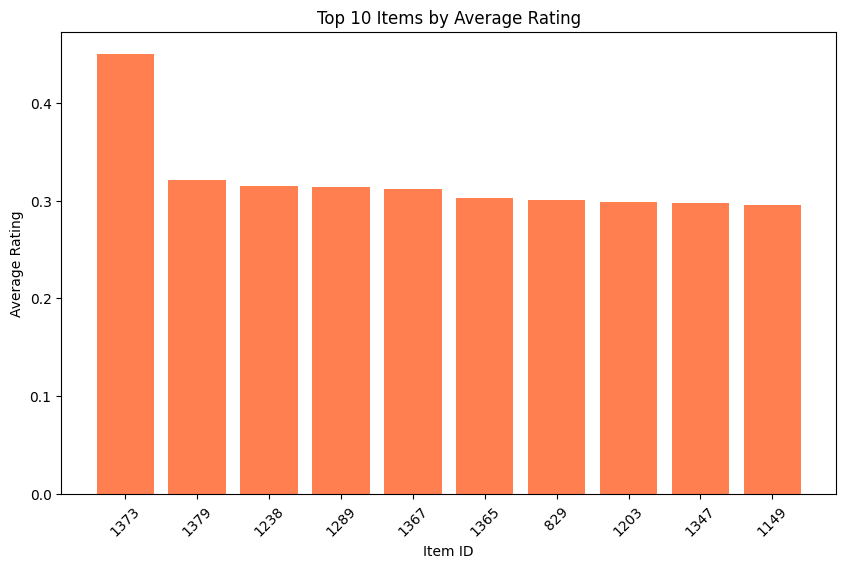

In [ ]:
# Explode recommendations to get item_id and rating for all users
exploded_recommendations = user_recommendations.withColumn("recommendation", explode(col("recommendations"))) \
    .select("user_id", col("recommendation.item_id").alias("item_id"), col("recommendation.rating").alias("rating"))

# Calculate average rating for each item
average_ratings = exploded_recommendations.groupBy("item_id").agg(avg("rating").alias("average_rating"))

average_ratings_df = average_ratings.orderBy(col("average_rating").desc()).limit(10).toPandas()

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(average_ratings_df["item_id"].astype(str), average_ratings_df["average_rating"], color="coral")
plt.xlabel("Item ID")
plt.ylabel("Average Rating")
plt.title("Top 10 Items by Average Rating")
plt.xticks(rotation=45)
plt.show()

In [ ]:
flattened_recommendations = final_recommendations.withColumn(
    "recommendations",
    concat_ws(
        ", ",
        col("recommendations").cast("string")  # Convert array of structs to a string
    )
)

# Save to CSV
flattened_recommendations.write.csv("Final_Recommendation.csv", header=True)